In [108]:
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from tokenizers import Tokenizer, models, trainers
from tokenizers.normalizers import NFKC
from tokenizers.pre_tokenizers import Whitespace
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

In [51]:
ds = load_dataset("WhereIsAI/github-issue-similarity", "default")

In [52]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 18565
    })
    valid: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 1547
    })
    test: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 1548
    })
})


In [53]:
texts = []

for split in tqdm(["train", "valid", "test"]):
    texts.extend(ds[split]["text1"])
    texts.extend(ds[split]["text2"])

  0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
print(len(texts))

43320


In [9]:
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = Whitespace()

In [ ]:
trainer = trainers.BpeTrainer(vocab_size=30522)
tokenizer.train_from_iterator(texts, trainer=trainer)

In [11]:
tokenizer.save("perfect_tokenizer.json")

In [17]:
tokenizer_perfect = Tokenizer.from_file("perfect_tokenizer.json")

In [9]:
vocab = tokenizer.get_vocab()
print(len(vocab))

30522


In [10]:
sample = ds["train"]["text1"][0]

print("Sample text:")
print("*"*80)
print(sample)
print("\n\n")
print("Encoded text:")
print("*"*80)
print(tokenizer.encode(sample).tokens)

Sample text:
********************************************************************************
<h3 dir="auto">Feature request</h3>
<p dir="auto">Whisper speech recognition without conditioning on previous text.<br>
As in <a href="https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278">https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278</a></p>
<h3 dir="auto">Motivation</h3>
<p dir="auto">Whisper implementation is great however conditioning the decoding on previous text can cause significant hallucination and repetitive text, e.g.:</p>
<blockquote>
<p dir="auto">"Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? 

In [55]:
def get_n_tokens(sample, tokenizer, key="token_length"):
    try:
        return {
            f"{key}_text1": len(tokenizer.encode(sample["text1"], add_special_tokens=False).tokens),
            f"{key}_text2": len(tokenizer.encode(sample["text2"], add_special_tokens=False).tokens)
        }
    except:
        return {
            f"{key}_text1": len(tokenizer(sample["text1"], add_special_tokens=False).input_ids),
            f"{key}_text2": len(tokenizer(sample["text2"], add_special_tokens=False).input_ids)
        }


In [56]:
ds = ds.map(lambda x: get_n_tokens(x, tokenizer_perfect), num_proc=8)

Map:   0%|          | 0/18565 [00:00<?, ? examples/s]

Map:   0%|          | 0/1547 [00:00<?, ? examples/s]

Map:   0%|          | 0/1548 [00:00<?, ? examples/s]

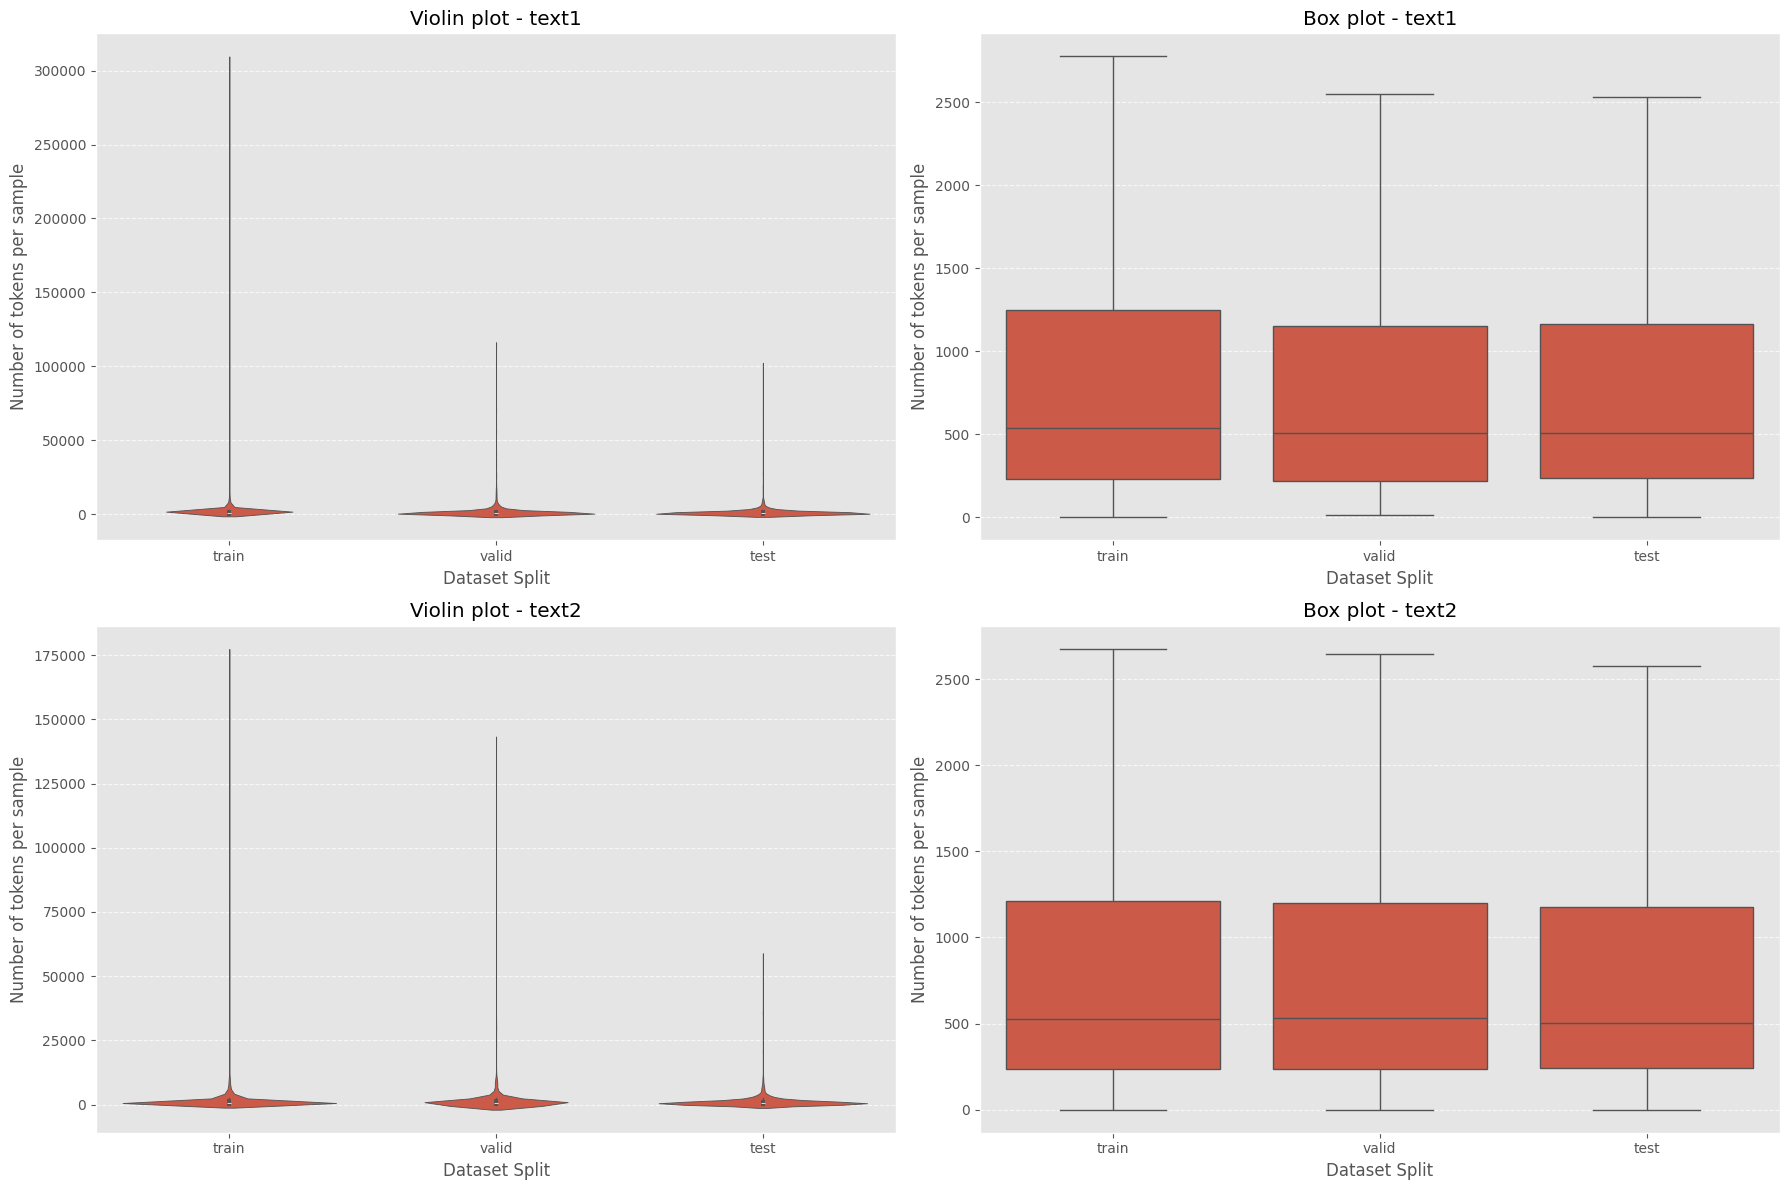

In [58]:
data_text1 = []
labels_text1 = []
data_text2 = []
labels_text2 = []

for split in ["train", "valid", "test"]:
    data_text1.extend(ds[split]["token_length_text1"])
    labels_text1.extend([split] * len(ds[split]["token_length_text1"]))

    data_text2.extend(ds[split]["token_length_text2"])
    labels_text2.extend([split] * len(ds[split]["token_length_text2"]))

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)

sns.violinplot(x=labels_text1, y=data_text1, inner="box", ax=axes[0, 0])
axes[0, 0].set_xlabel("Dataset Split")
axes[0, 0].set_ylabel("Number of tokens per sample")
axes[0, 0].set_title("Violin plot - text1")
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=labels_text1, y=data_text1, ax=axes[0, 1], showfliers=False)
axes[0, 1].set_xlabel("Dataset Split")
axes[0, 1].set_ylabel("Number of tokens per sample")
axes[0, 1].set_title("Box plot - text1")
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

sns.violinplot(x=labels_text2, y=data_text2, inner="box", ax=axes[1, 0])
axes[1, 0].set_xlabel("Dataset Split")
axes[1, 0].set_ylabel("Number of tokens per sample")
axes[1, 0].set_title("Violin plot - text2")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=labels_text2, y=data_text2, ax=axes[1, 1], showfliers=False)
axes[1, 1].set_xlabel("Dataset Split")
axes[1, 1].set_ylabel("Number of tokens per sample")
axes[1, 1].set_title("Box plot - text2")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

> SBERT based on the BERT architecture are not adapted here, because even with a perfect tokenizer, we will truncate the majority of the samples
> Thus we select good candidates based on the size of our sampled and the performances in MTEB

In [59]:
models = {
    "Alibaba-NLP/gte-base-en-v1.5": 8192,
    # "jxm/cde-small-v2": 768,
    "bert-base-uncased": 512,  # The tokenizer used by cde-small-v2 is the same as bert-base-uncased (see hf repo)
    "NovaSearch/stella_en_400M_v5": 8192,
}

tokenizers = {model: AutoTokenizer.from_pretrained(model) for model in models}

In [60]:
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["Alibaba-NLP/gte-base-en-v1.5"], key="gte_token_length"), num_proc=8)
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["bert-base-uncased"], key="cde_token_length"), num_proc=8)
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["NovaSearch/stella_en_400M_v5"], key="stella_token_length"), num_proc=8)

Map:   0%|          | 0/18565 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (64333 > 32768). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1547 [00:00<?, ? examples/s]

Map:   0%|          | 0/1548 [00:00<?, ? examples/s]

Map:   0%|          | 0/18565 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1547 [00:00<?, ? examples/s]

Map:   0%|          | 0/1548 [00:00<?, ? examples/s]

Map:   0%|          | 0/18565 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (64333 > 32768). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1547 [00:00<?, ? examples/s]

Map:   0%|          | 0/1548 [00:00<?, ? examples/s]

In [62]:
ds

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'token_length_text1', 'token_length_text2', 'gte_token_length_text1', 'gte_token_length_text2', 'cde_token_length_text1', 'cde_token_length_text2', 'stella_token_length_text1', 'stella_token_length_text2'],
        num_rows: 18565
    })
    valid: Dataset({
        features: ['text1', 'text2', 'label', 'token_length_text1', 'token_length_text2', 'gte_token_length_text1', 'gte_token_length_text2', 'cde_token_length_text1', 'cde_token_length_text2', 'stella_token_length_text1', 'stella_token_length_text2'],
        num_rows: 1547
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'token_length_text1', 'token_length_text2', 'gte_token_length_text1', 'gte_token_length_text2', 'cde_token_length_text1', 'cde_token_length_text2', 'stella_token_length_text1', 'stella_token_length_text2'],
        num_rows: 1548
    })
})

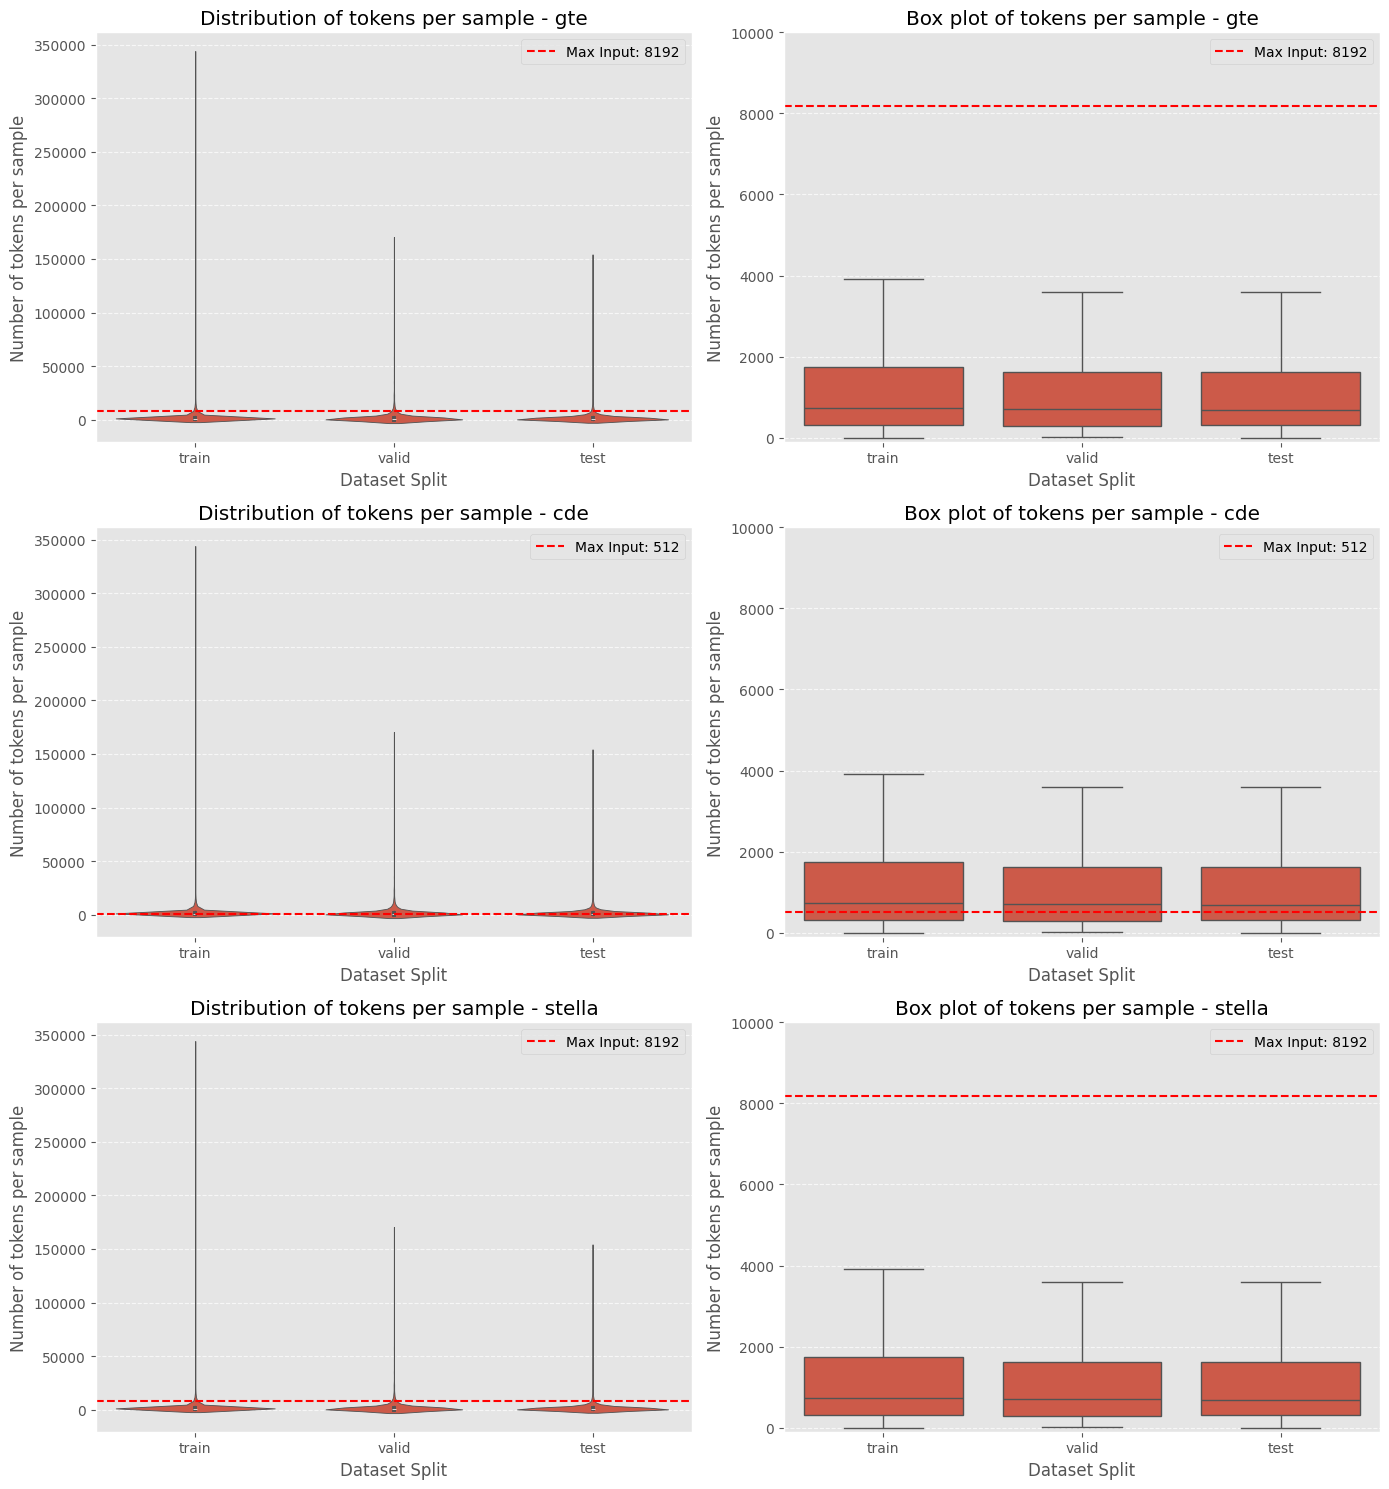

In [67]:
models = {
    "gte": 8192,
    "cde": 512,
    "stella": 8192,
}

fig, axes = plt.subplots(len(models), 2, figsize=(14, 15), sharey=False)

for (model_key, max_length), ax in zip(models.items(), axes):
    data = []
    labels = []

    for split in ["train", "valid", "test"]:
        token_length_column = f"{model_key}_token_length_text1"
        
        data.extend(ds[split][token_length_column])
        labels.extend([split] * len(ds[split][token_length_column]))

    sns.violinplot(x=labels, y=data, inner="box", ax=ax[0])
    ax[0].axhline(y=max_length, color='r', linestyle='--', label=f"Max Input: {max_length}")
    ax[0].set_xlabel("Dataset Split")
    ax[0].set_ylabel("Number of tokens per sample")
    ax[0].set_title(f"Distribution of tokens per sample - {model_key}")
    ax[0].grid(axis="y", linestyle="--", alpha=0.7)
    ax[0].legend()

    sns.boxplot(x=labels, y=data, ax=ax[1], showfliers=False)
    ax[1].axhline(y=max_length, color='r', linestyle='--', label=f"Max Input: {max_length}")
    ax[1].set_xlabel("Dataset Split")
    ax[1].set_ylabel("Number of tokens per sample")
    ax[1].set_title(f"Box plot of tokens per sample - {model_key}")
    ax[1].set_ylim(-100, 10000)
    ax[1].grid(axis="y", linestyle="--", alpha=0.7)
    ax[1].legend()

plt.tight_layout()
plt.show()

> As we can see, for each dataset with a max context size of 512 tokens we cover less than 25 % of the samples, so truncate the sequences can lead to a lost of information  
> But as we can see, with 8192 we won't truncate the large majority of the samples  

In [68]:
np.corrcoef(ds["train"]["gte_token_length_text1"], ds["train"]["cde_token_length_text1"])

array([[1., 1.],
       [1., 1.]])

> The three models are using the `bert-base-uncased` vocab, so we can compare the alignement of the our training set with training set used for pre-training this model (trick)

In [74]:
print(ds["train"][0])
print(ds["train"][1])
print(ds["train"][2001])
print(ds["train"][432])

{'text1': '<h3 dir="auto">Feature request</h3>\n<p dir="auto">Whisper speech recognition without conditioning on previous text.<br>\nAs in <a href="https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278">https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278</a></p>\n<h3 dir="auto">Motivation</h3>\n<p dir="auto">Whisper implementation is great however conditioning the decoding on previous text can cause significant hallucination and repetitive text, e.g.:</p>\n<blockquote>\n<p dir="auto">"Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice?"</

> There is a lot of HTML tags, we can remove them with a regex or or bs4 (better)

In [83]:
def remove_html_tags(sample):
    sample["text1"] = BeautifulSoup(sample["text1"], "html.parser").get_text().strip()
    sample["text2"] = BeautifulSoup(sample["text2"], "html.parser").get_text().strip()
    return sample

In [84]:
sample = ds["train"][0]

print("Sample text:")
print("*"*80)
print(sample["text1"])
print("\n\n")
print("Text without HTML tags:")
print("*"*80)
print(remove_html_tags(sample)["text1"])

Sample text:
********************************************************************************
<h3 dir="auto">Feature request</h3>
<p dir="auto">Whisper speech recognition without conditioning on previous text.<br>
As in <a href="https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278">https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278</a></p>
<h3 dir="auto">Motivation</h3>
<p dir="auto">Whisper implementation is great however conditioning the decoding on previous text can cause significant hallucination and repetitive text, e.g.:</p>
<blockquote>
<p dir="auto">"Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? 

In [88]:
ds = ds.map(remove_html_tags, num_proc=8)

Map (num_proc=8):   0%|          | 0/18565 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1547 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1548 [00:00<?, ? examples/s]

In [90]:
ds = ds.map(lambda x: get_n_tokens(x, tokenizer_perfect, key="token_length_cleaned"), num_proc=8)

Map (num_proc=8):   0%|          | 0/18565 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1547 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1548 [00:00<?, ? examples/s]

In [95]:
ds

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'token_length_text1', 'token_length_text2', 'gte_token_length_text1', 'gte_token_length_text2', 'cde_token_length_text1', 'cde_token_length_text2', 'stella_token_length_text1', 'stella_token_length_text2', 'token_length_cleaned_text1', 'token_length_cleaned_text2'],
        num_rows: 18565
    })
    valid: Dataset({
        features: ['text1', 'text2', 'label', 'token_length_text1', 'token_length_text2', 'gte_token_length_text1', 'gte_token_length_text2', 'cde_token_length_text1', 'cde_token_length_text2', 'stella_token_length_text1', 'stella_token_length_text2', 'token_length_cleaned_text1', 'token_length_cleaned_text2'],
        num_rows: 1547
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'token_length_text1', 'token_length_text2', 'gte_token_length_text1', 'gte_token_length_text2', 'cde_token_length_text1', 'cde_token_length_text2', 'stella_token_length_text1', 'stella_token_

In [92]:
print(f"Mean number of tokens per sample in text1: {np.mean(ds['train']['token_length_text1'])}")
print(f"Mean number of tokens per sample in text2: {np.mean(ds['train']['token_length_text2'])}")
print("*"*80)
print(f"Mean number of tokens per sample in text1 (cleaned): {np.mean(ds['train']['token_length_cleaned_text1'])}")
print(f"Mean number of tokens per sample in text2 (cleaned): {np.mean(ds['train']['token_length_cleaned_text2'])}")

Mean number of tokens per sample in text1: 1442.647239429033
Mean number of tokens per sample in text2: 1332.967250201993
********************************************************************************
Mean number of tokens per sample in text1 (cleaned): 569.109668731484
Mean number of tokens per sample in text2 (cleaned): 506.06382978723406


In [94]:
print(ds["train"]["text1"][2136])

Context:

Playwright Version: [1.19]

Describe the bug
In this below POM demonstration example, visibility check element is duplicated. This is misleading in POM context. So documentation needs to updated.
https://playwright.dev/docs/test-pom
Expected:
await expect(this.coreConceptsLink).toBeVisible();
As "this.coreConceptsLink = page.locator('text=Core concepts');"
is already defined in PlaywrightDevPage constructor
Actual
await expect(this.page.locator('h1').locator("text=Core concepts")).toBeVisible();
Add any other details about the problem here.



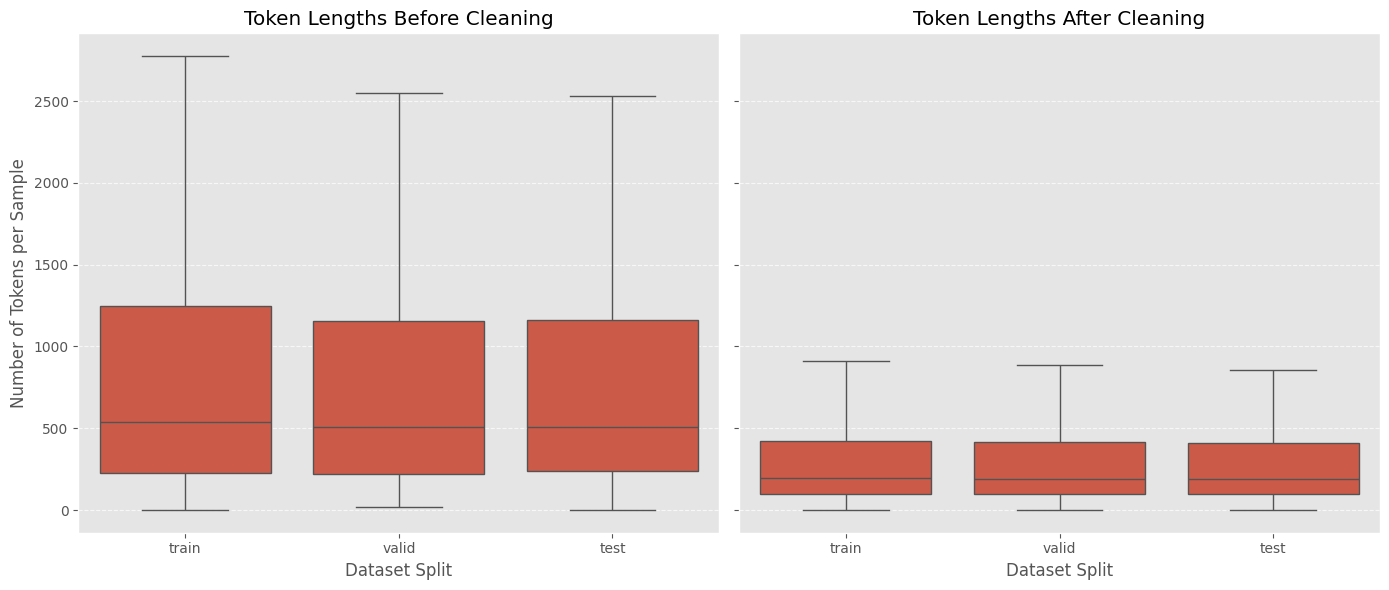

In [97]:
raw_data = []
raw_labels = []
clean_data = []
clean_labels = []

for split in ["train", "valid", "test"]:
    raw_data.extend(ds[split]["token_length_text1"])
    raw_labels.extend([split] * len(ds[split]["token_length_text1"]))

    clean_data.extend(ds[split]["token_length_cleaned_text1"])
    clean_labels.extend([split] * len(ds[split]["token_length_cleaned_text1"]))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(x=raw_labels, y=raw_data, ax=axes[0], showfliers=False)
axes[0].set_title("Token Lengths Before Cleaning")
axes[0].set_xlabel("Dataset Split")
axes[0].set_ylabel("Number of Tokens per Sample")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=clean_labels, y=clean_data, ax=axes[1], showfliers=False)
axes[1].set_title("Token Lengths After Cleaning")
axes[1].set_xlabel("Dataset Split")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [98]:
# let's look with the bert tokenizer
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["bert-base-uncased"], key="bert_token_length_cleaned"), num_proc=8)

Map (num_proc=8):   0%|          | 0/18565 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1547 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1548 [00:00<?, ? examples/s]

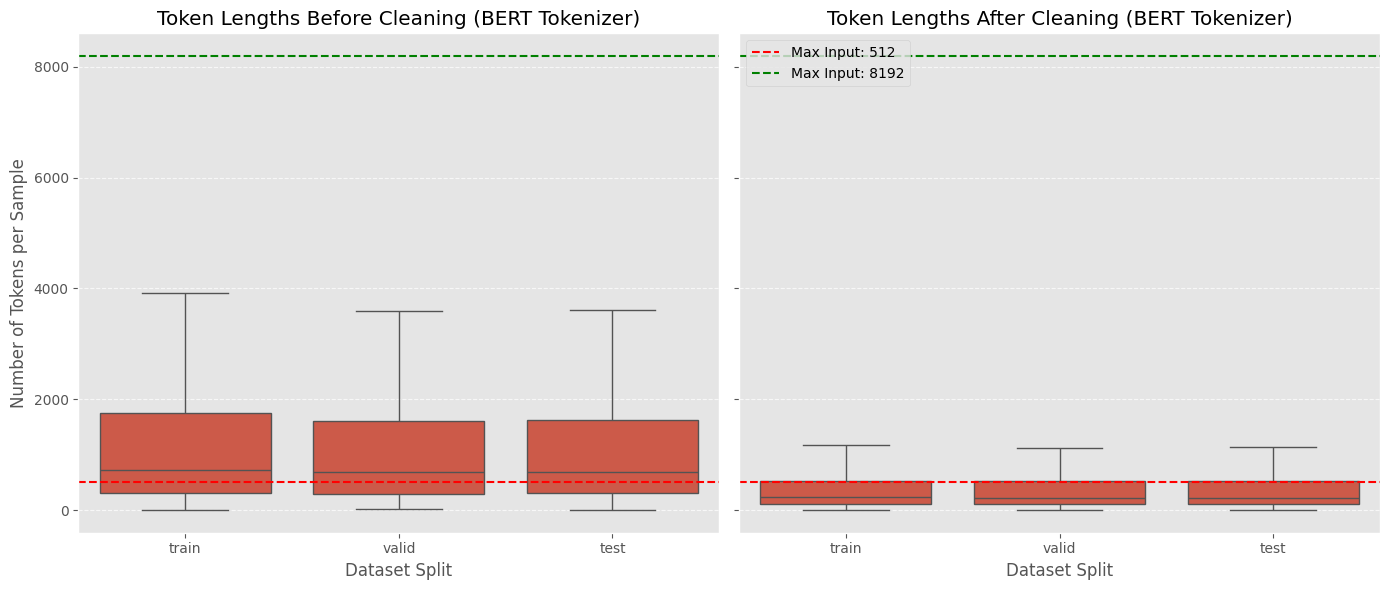

In [106]:
raw_data = []
raw_labels = []
clean_data = []
clean_labels = []

for split in ["train", "valid", "test"]:
    raw_data.extend(ds[split]["cde_token_length_text1"])
    raw_labels.extend([split] * len(ds[split]["cde_token_length_text1"]))

    clean_data.extend(ds[split]["bert_token_length_cleaned_text1"])
    clean_labels.extend([split] * len(ds[split]["bert_token_length_cleaned_text1"]))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(x=raw_labels, y=raw_data, ax=axes[0], showfliers=False)
axes[0].set_title("Token Lengths Before Cleaning (BERT Tokenizer)")
axes[0].axhline(y=512, color='r', linestyle='--', label=f"Max Input: 512")
axes[0].axhline(y=8192, color='g', linestyle='--', label=f"Max Input: 8192")
axes[0].set_xlabel("Dataset Split")
axes[0].set_ylabel("Number of Tokens per Sample")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=clean_labels, y=clean_data, ax=axes[1], showfliers=False)
axes[1].set_title("Token Lengths After Cleaning (BERT Tokenizer)")
axes[1].axhline(y=512, color='r', linestyle='--', label=f"Max Input: 512")
axes[1].axhline(y=8192, color='g', linestyle='--', label=f"Max Input: 8192")
axes[1].set_xlabel("Dataset Split")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

> By removing all these useless tags, the size of the samples decreased consequently. Thanks to this preprocessing, a max context of 512 correspong now to the Q3, meaning that 75% of the samples have a size lower

In [107]:
train_df = ds["train"].to_pandas()
valid_df = ds["valid"].to_pandas()
test_df = ds["test"].to_pandas()

train_df.to_csv("../data/train.csv", index=False)
valid_df.to_csv("../data/valid.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)